In [27]:
import os
import pickle

import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm.autonotebook import tqdm

import torch
import torch.distributions as dist
import zuko

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

In [28]:
# model prior
a_1_model = torch.tensor(2750.0)
d_model   = torch.tensor(500.0 )

a_2_mean = torch.tensor([3750.0])
a_2_std = torch.tensor([300.0])
a_2_prior_dist = dist.Independent(dist.Normal(a_2_mean, a_2_std), 1)

# a_2_min = torch.tensor([3000.0])
# a_2_max = torch.tensor([4500.0])
# a_2_prior_dist = dist.Independent(dist.Uniform(a_2_min, a_2_max), 1)

In [29]:
class MDN_guide(torch.nn.Module):
    def __init__(self, data_features, model_features, design_features=0, **kwargs):

        self.data_mean = torch.ones(data_features)*0.5
        self.data_std  = torch.ones(data_features)*0.5
        
        initial_design = torch.tensor([0.0, 3500.0])
        
        self.design_mean = torch.ones(data_features)*initial_design.mean()
        self.design_std  = torch.ones(data_features)*initial_design.std()
        
        model_mean = torch.tensor([3750.0])
        model_std  = torch.tensor([750.0])
    
        super().__init__()
    
        self.base = zuko.flows.GMM(features=model_features, context=data_features+design_features, **kwargs)
        
        initial_means = a_2_prior_dist.sample((kwargs['components'],))
        
        min_index = self.base.sizes[0]
        max_index = self.base.sizes[0] + self.base.sizes[1]
        self.base.hyper[-1].bias.data[min_index:max_index]  = ((initial_means-model_mean)/model_std).flatten().detach()
        
        self.transforms = [zuko.flows.Unconditional(dist.AffineTransform, -model_mean/model_std, 1/model_std, buffer=True),]# buffer=True excludes the parameters from the optimization
    
    def forward(self, d, design=None):
        
        d = ((d-self.data_mean)/self.data_std)
        
        if design is not None:
            design = ((design-self.design_mean)/self.design_std)
            d = torch.cat([d, design.repeat(d.shape[0],1)], dim=-1)

        transform = zuko.transforms.ComposedTransform(*(t(d) for t in self.transforms))

        if d is None:
            base = self.base(d)
        else:
            base = self.base(d).expand(d.shape[:-1])

        return zuko.flows.NormalizingFlow(transform, base)
        
    def log_prob(self, m, d, design=None):
        
        out = self.forward(d, design).log_prob(m)
                
        return out
    
    def sample(self, d, n_samples, design=None):
        
        shape = torch.Size([n_samples])
        return self.forward(d, design).sample(shape).squeeze(0)

In [30]:
def data_likelihood(d, **kwargs):
    std_data = 0.05
    return dist.Independent(dist.Normal(d, torch.tensor(std_data)), 1)

def forward_function(offset, a_2):
    fwd_samples = calculate_avo(offset, a_1_model, a_2, d_model)
    # use rsample to sample with reparametrization trick to get gradients
    return data_likelihood(fwd_samples).rsample()

In [31]:
def sgd_design_optimisation(
    initial_design,
    fwd_function,
    n_steps,
    n_batch,
    guide,
    design_optimizer=None,
    guide_optimizer=None,
    design_scheduler=None,
    guide_scheduler=None,
    design_optimizer_args={},
    guide_optimizer_args={},
    design_scheduler_args={},
    guide_scheduler_args={},
    pass_design_to_guide=False,
    disable_tqdm=False,
    ):

    is_nan = False
    
    initial_design = initial_design.clone().detach().requires_grad_(True)
        
    losses = []
    design_history = []
    
    if design_optimizer is None:
        design_optimizer = torch.optim.Adam
    if guide_optimizer is None:
        guide_optimizer = torch.optim.Adam
    
    d_optim = design_optimizer([{'params': initial_design,}],
                               **design_optimizer_args)
    g_optim = guide_optimizer(guide.parameters(),
                              **guide_optimizer_args)
    
    class dummy_scheduler:
        def step(self):
            pass
    
    d_sched = design_scheduler(d_optim, **design_scheduler_args) if design_scheduler is not None else dummy_scheduler()
    g_sched = guide_scheduler(g_optim, **guide_scheduler_args) if guide_scheduler is not None else dummy_scheduler()
    
    isnan = False

    for step in (pbar := tqdm(range(n_steps), desc='Loss: 0.000', miniters=int(n_steps/1000), position=1, disable=disable_tqdm)):
    
    
        d_optim.zero_grad()
        g_optim.zero_grad()
        
        model_batch = a_2_prior_dist.sample((n_batch,))      
        
        data_batch = fwd_function(initial_design, model_batch)
                
        if not pass_design_to_guide:
            loss = -guide.log_prob(model_batch, data_batch).mean()
        else:            
            loss = -guide.log_prob(model_batch, data_batch, initial_design).mean()

        loss.backward()
        
        initial_design.grad.data = torch.nan_to_num(initial_design.grad.data, (torch.randn(1)*1e-6).item())
        
        d_optim.step()
        g_optim.step()
                
        d_sched.step()
        g_sched.step()
        
        with torch.no_grad():
             initial_design.clamp_(min=-3500.0, max=3500.0)
                
        losses.append(loss.item())
        design_history.append(abs(initial_design.detach().numpy()).copy())
        
        if step % 100 == 0:
            pbar.set_description(f"Loss: {loss.detach().item():.3f}")
            pbar.update(1)
    
    return losses, design_history

In [32]:
n_steps = 100000
n_batch = 1

guide = MDN_guide(data_features=2, model_features=1, design_features=2, components=10, hidden_features=[40, 40, 40], normalize=True)

d_optim = torch.optim.Adam
d_optim_args = {'lr': 3.5}
d_scheduler = torch.optim.lr_scheduler.StepLR
d_scheduler_args = {'step_size': int(n_steps/4), 'gamma': 0.3}

g_optim = torch.optim.Adam
g_optim_args = {'lr': 0.001}
g_scheduler = torch.optim.lr_scheduler.StepLR
g_scheduler_args = {'step_size': int(n_steps/4), 'gamma': 0.3}

In [33]:
worst_initial_design = torch.tensor([100.0, 3400.0])

filename = 'data/avo_onestep_2rec_worst.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    losses_worst_start = np.array(results[0])
    design_history_worst_start = np.array(results[1])
    
else:
    print(f'File {filename} does not exist. Calculating eig values.')

    results = sgd_design_optimisation(
        initial_design=worst_initial_design,
        fwd_function=forward_function,
        n_steps=n_steps,
        n_batch=n_batch,
        guide=guide,
        design_optimizer=d_optim,
        guide_optimizer=g_optim,
        design_scheduler=d_scheduler,
        guide_scheduler=g_scheduler,
        design_optimizer_args=d_optim_args,
        guide_optimizer_args=g_optim_args,
        design_scheduler_args=d_scheduler_args,
        guide_scheduler_args=g_scheduler_args,
        pass_design_to_guide=True,
    )
   
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    losses_worst_start = np.array(results[0])
    design_history_worst_start = np.array(results[1])
    
del results


Loading eig values from data/avo_onestep_2rec_worst.pkl


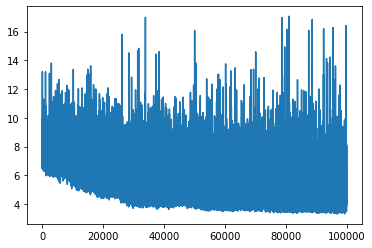

In [34]:
plt.plot(losses_worst_start)
plt.show()

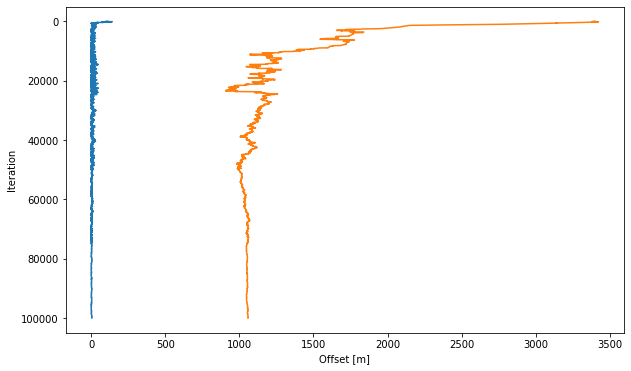

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(design_history_worst_start, range(len(design_history_worst_start)))
# ax.plot(design_history_worst_start, range(n_steps))

ax.invert_yaxis()

# ax.set_xlim(-100, 3500)

ax.set_ylabel('Iteration')

ax.set_xlabel('Offset [m]')

plt.show()


In [36]:
best_initial_design = torch.tensor([1166.0, 2333.0])

filename = 'data/avo_onestep_2rec_best.pkl'


if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    losses_best_start = np.array(results[0])
    design_history_best_start = np.array(results[1])
    
else:
    print(f'File {filename} does not exist. Calculating eig values.')

    results = sgd_design_optimisation(
        initial_design=best_initial_design,
        fwd_function=forward_function,
        n_steps=n_steps,
        n_batch=n_batch,
        guide=guide,
        design_optimizer=d_optim,
        guide_optimizer=g_optim,
        design_scheduler=d_scheduler,
        guide_scheduler=g_scheduler,
        design_optimizer_args=d_optim_args,
        guide_optimizer_args=g_optim_args,
        design_scheduler_args=d_scheduler_args,
        guide_scheduler_args=g_scheduler_args,
        pass_design_to_guide=True,
    )

   
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    losses_best_start = np.array(results[0])
    design_history_best_start = np.array(results[1])
    
del results

Loading eig values from data/avo_onestep_2rec_best.pkl


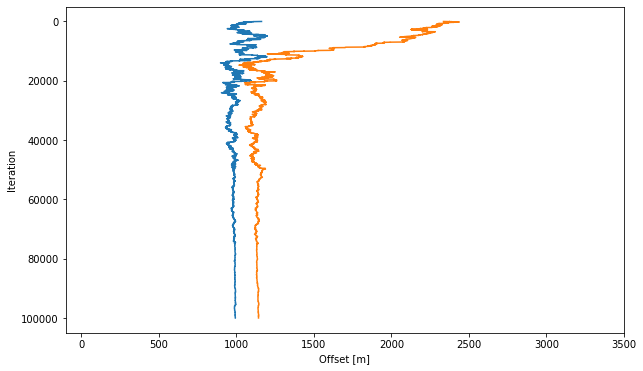

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(design_history_best_start, range(n_steps))

ax.invert_yaxis()

ax.set_xlim(-100, 3500)

ax.set_ylabel('Iteration')
ax.set_xlabel('Offset [m]')

plt.show()


In [38]:
import pickle

import dill
dill.settings['recurse'] = True # allow pickling of functions and classes

from mpire import WorkerPool as Pool

In [39]:
import contextlib

import joblib
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler

set_loky_pickler('dill')

n_initial_designs = 100
torch.manual_seed(1)

random_design_list = [[torch.FloatTensor(2).uniform_(100, 3500).sort()[0],] for _ in range(n_initial_designs)]

num_workers = 10
filename = 'data/avo_onestep_2rec_results.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
else:
    print(f'File {filename} does not exist. Calculating eig values.')

    losses_collection = []
    design_history_collection = []
            
    def worker(design):
        
        design = design[0]
                                
        return sgd_design_optimisation(
            initial_design=design,
            fwd_function=forward_function,
            n_steps=n_steps,
            n_batch=n_batch,
            guide=guide,
            design_optimizer=None,
            guide_optimizer=None,
            design_scheduler=d_scheduler,
            guide_scheduler=g_scheduler,
            design_optimizer_args=d_optim_args,
            guide_optimizer_args=g_optim_args,
            design_scheduler_args=d_scheduler_args,
            guide_scheduler_args=g_scheduler_args,
            disable_tqdm=True,
            pass_design_to_guide=True,
            )

    @contextlib.contextmanager
    def tqdm_joblib(tqdm_object):
        """Context manager to patch joblib to report into tqdm progress bar given as argument"""
        class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
            def __call__(self, *args, **kwargs):
                tqdm_object.update(n=self.batch_size)
                return super().__call__(*args, **kwargs)

        old_batch_callback = joblib.parallel.BatchCompletionCallBack
        joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        try:
            yield tqdm_object
        finally:
            joblib.parallel.BatchCompletionCallBack = old_batch_callback
            tqdm_object.close()

    with tqdm_joblib(tqdm(desc="Calculating eig", position=1, total=len(random_design_list))) as progress_bar:
        results = Parallel(n_jobs=num_workers)(delayed(worker)(design) for design in random_design_list)

    with open(filename, 'wb') as f:
        pickle.dump(results, f)

losses_collection, design_history_collection = zip(*results)

losses_collection = np.array(losses_collection)
design_history_collection = np.array(design_history_collection)

Loading eig values from data/avo_onestep_2rec_results.pkl


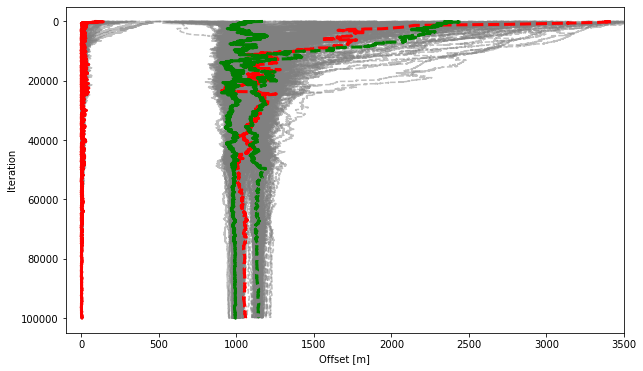

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(n_initial_designs):
    
    ax.plot(design_history_collection[i, :, 0].T, range(n_steps), color='grey', alpha=0.5)
    ax.plot(design_history_collection[i, :, 1].T, range(n_steps), color='grey', linestyle='--', alpha=0.5)

ax.plot(design_history_worst_start[:, 0], range(n_steps), color='red', linewidth=3)
ax.plot(design_history_worst_start[:, 1], range(n_steps), color='red', linewidth=3, linestyle='--')

ax.plot(design_history_best_start[:, 0], range(n_steps), color='green', linewidth=3)
ax.plot(design_history_best_start[:, 1], range(n_steps), color='green', linewidth=3,
        linestyle='--')

ax.invert_yaxis()

ax.set_xlim(-100, 3500)
    
ax.set_ylabel('Iteration')
ax.set_xlabel('Offset [m]')

fig.savefig('figures/avo_onestep_2rec_designs_design_history.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_onestep_2rec_designs_design_history.png', bbox_inches='tight',
            dpi=120, transparent=True)

plt.show()


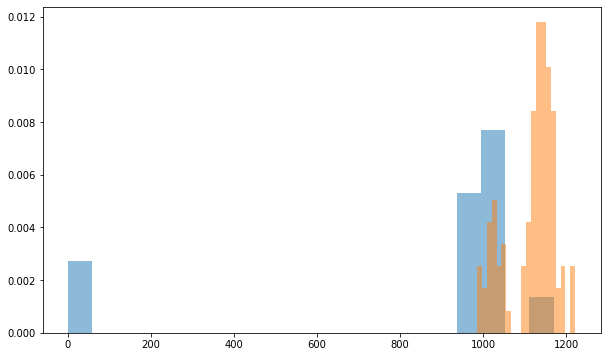

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(design_history_collection[:, -1, 0],
        bins=20, density=True, alpha=0.5, label='Offset 1')
ax.hist(design_history_collection[:, -1, 1],
        bins=20, density=True, alpha=0.5, label='Offset 2')

# ax.set_xlim(-10, 2000)


plt.show()

In [42]:
import pickle
import os
import numpy as np

filename = 'data/avo_gaussian_2rec_global_optimum_eig.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        
    eig_global, info_global = results
else:
    print(f'File {filename} does not exist. Calculate in other file.')


Loading eig values from data/avo_gaussian_2rec_global_optimum_eig.pkl


In [43]:
from itertools import product

design_names = [str(i) for i in range(200)]
offsets      = torch.linspace(1.0, 3500.0, 200)

global_design_grid = list(product(design_names, design_names))

grid_optimal_design = global_design_grid[torch.argmax(eig_global)]
grid_optimal_design = torch.stack([offsets[int(i)] for i in grid_optimal_design])

print(grid_optimal_design)

tensor([ 950.4774, 1091.1407])


In [44]:
n_design_points = 200
design_names = [str(i) for i in range(n_design_points)]
offsets = np.linspace(100, 3500, n_design_points)

torch.manual_seed(0)

prior_samples = a_2_prior_dist.sample((int(2e7),))

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function, 'dataset': 'data', 'cost': 1.0,}

def constructor_1to1_design(self, name_list, n_samples):
        
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
    
    data = torch.zeros((n_samples, len(name_list), 2))

    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](d_meta['offset'], self.prior_samples[:n_samples])

    return data.flatten(start_dim=-2)

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                         design2data=constructor_1to1_design)


iterative_benchmark, iterative_benchmark_info_dict = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=2,
    eig_method='nmc',
    eig_method_kwargs={'N':int(1e4), 'M':int(1e3), 'reuse_M_samples':False},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=50,
    filename='data/avo_gaussian_2rec_iterative_nmc_benchmark_eig.pkl',
    # parallel_method='joblib',
    )

iterative_benchmark_design = np.array([design_dicts[d]['offset'] for d in iterative_benchmark], dtype=np.float32)
print(iterative_benchmark_design)

[ 971.3568 1193.4673]


In [45]:
heuristic_design = torch.tensor([750.0, 1250.0])

optimal_designs = np.concatenate( [design_history_collection[:, -1, :],
                                   heuristic_design[None, :],
                                   design_history_best_start[None, -1, :],
                                   design_history_worst_start[None, -1, :],
                                   iterative_benchmark_design[None, :],
                                   grid_optimal_design[None, :]], dtype=np.float32)

# print(optimal_designs)
print(optimal_designs.shape)

design_names_benchmark = [str(i) for i in range(len(optimal_designs))]

design_dicts_benchmark = {}

for i, name in enumerate(design_names_benchmark):
    design_dicts_benchmark[name] = {'index': i, 'offset': optimal_designs[i], 'forward_function': forward_function, 'dataset': 'data', 'cost': 1.0,}
    
BED_class_benchmark = BED_discrete(design_dicts_benchmark, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                                   design2data=constructor_1to1_design)

(105, 2)


In [46]:
print(optimal_designs[-6:])

[[ 999.65247   1110.2471   ]
 [ 750.        1250.       ]
 [ 993.6658    1143.14     ]
 [   3.2220383 1058.508    ]
 [ 971.3568    1193.4673   ]
 [ 950.47736   1091.1407   ]]


In [47]:
test_data = BED_class_benchmark.get_forward_samples(design_names_benchmark[:1], n_samples=1000)

print(test_data.shape)

torch.Size([1000, 2])


In [48]:
eig_benchmark, info_benchmark = BED_class_benchmark.calculate_eig_list(
     [[d,] for d in design_names_benchmark],
     'nmc',
     method_kwargs={'N':int(1e4), 'M':int(1e4), 'reuse_M_samples':True},
     num_workers=50,
     progress_bar=True,
     random_seed=0,
     parallel_method='joblib',
     filename='data/avo_gaussian_2rec_nmc_benchmark_eig.pkl',   
)

In [49]:
design_names_random = [str(i) for i in range(len(torch.stack([r[0] for r in random_design_list])))]

design_dicts_random = {}

for i, name in enumerate(design_names_random):
    design_dicts_random[name] = {'index': i, 'offset': torch.stack([r[0] for r in random_design_list])[i], 'forward_function': forward_function, 'dataset': 'data', 'cost': 1.0,}
    
BED_class_random = BED_discrete(design_dicts_random, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                                design2data=constructor_1to1_design)

In [50]:
eig_random, info_random = BED_class_random.calculate_eig_list(
     [[d,] for d in design_names_random],
     'nmc',
     method_kwargs={'N':int(1e4), 'M':int(1e4), 'reuse_M_samples':True},
     num_workers=10,
     progress_bar=True,
     random_seed=0,
     parallel_method='joblib',
     filename='data/avo_gaussian_2rec_nmc_random_eig.pkl',   
)

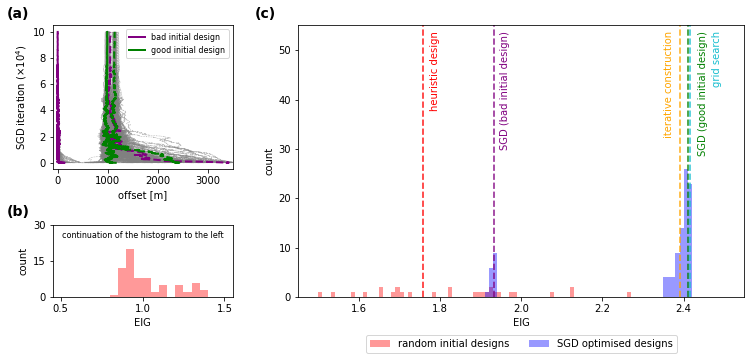

In [59]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

ax.hist(eig_random, bins=100, alpha=0.4, label='random initial designs', density=False, color='red', zorder=-1,
        range=(1.5, 2.5)
        )

ax.hist(eig_benchmark[:100], bins=100, alpha=0.4, label='SGD optimised designs', density=False, color='blue',
        range=(1.5, 2.5)
        )

# in_ax = inset_axes(ax, width='30%', height=1.2, loc=3, borderpad=3)

in_ax = inset_axes(ax, width=2.5, height=1.0, bbox_to_anchor=(-0.55, 0.0), loc=3, bbox_transform=ax.transAxes, borderpad=0.0, axes_kwargs={'facecolor':'white'})
in_ax.patch.set_alpha(0.0)

in_ax.hist(eig_random, bins=20, alpha=0.4, density=False, color='red', range=(0.5, 1.5), zorder=-1)
in_ax.hist(eig_benchmark[:-4], bins=20, alpha=0.4, density=False, color='blue', range=(0.5, 1.5))
in_ax.set_ylim(0, 20)
in_ax.set_xticks([0.5, 1.0, 1.5])
in_ax.set_yticks([0, 15, 30])
in_ax.set_ylabel('count')
in_ax.set_xlabel('EIG')

in_ax.text(0.5, 0.85, 'continuation of the histogram to the left', fontsize=8, transform=in_ax.transAxes, horizontalalignment='center', verticalalignment='center')

ax.set_ylim([0, 55])
vertical_offset = ax.get_ylim()[1] * 0.98
fontsize = 10

ymin = 0.0
lw=1.7

ax.axvline(eig_benchmark[-1], ymin=ymin, color='tab:cyan' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,
        #    label='grid search'
           )
ax.text(eig_benchmark[-1]+0.055, vertical_offset, 'grid search', rotation=90, color='tab:cyan', fontsize=fontsize, verticalalignment='top')

ax.axvline(eig_benchmark[-2], ymin=ymin, color='orange', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,
        #    label='iterative construction'
           )
ax.text(eig_benchmark[-2]-0.040, vertical_offset, 'iterative construction', rotation=90, color='orange', fontsize=fontsize, verticalalignment='top')


ax.axvline(eig_benchmark[-3], ymin=ymin, color='purple', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,
        #    label='unreasonable design prior'
           )
ax.text(eig_benchmark[-3]+0.015, vertical_offset, 'SGD (bad initial design)', rotation=90, color='purple', fontsize=fontsize, verticalalignment='top')


ax.axvline(eig_benchmark[-4], ymin=ymin, color='green' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,
        #    label='reasonable design prior'
           )
ax.text(eig_benchmark[-4]+0.025, vertical_offset, 'SGD (good initial design)', rotation=90, color='green', fontsize=fontsize, verticalalignment='top')

ax.axvline(eig_benchmark[-5], ymin=ymin, color='red' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,
        #    label='heuristic design'
           )
ax.text(eig_benchmark[-5]+0.015, vertical_offset, 'heuristic design', rotation=90, color='red', fontsize=fontsize, verticalalignment='top', )


in_ax_2 = inset_axes(ax, width=2.5, height=2.0, bbox_to_anchor=(-0.55, 1.0), loc=2, bbox_transform=ax.transAxes, borderpad=0.0, axes_kwargs={'facecolor':'white'})
in_ax_2.patch.set_alpha(0.0)

for i in range(n_initial_designs):
    
    in_ax_2.plot(design_history_collection[i, :, 0].T, np.array(range(n_steps))/1e4, color='grey', linewidth=0.5, alpha=0.5)
    in_ax_2.plot(design_history_collection[i, :, 1].T, np.array(range(n_steps))/1e4, color='grey', linewidth=0.5, linestyle='--', alpha=0.5)

in_ax_2.plot(design_history_worst_start[:, 0], np.array(range(n_steps))/1e4, color='purple', linewidth=2, label='bad initial design')
in_ax_2.plot(design_history_worst_start[:, 1], np.array(range(n_steps))/1e4, color='purple', linewidth=2, linestyle='--')

in_ax_2.plot(design_history_best_start[:, 0], np.array(range(n_steps))/1e4, color='green', linewidth=2, label='good initial design')
in_ax_2.plot(design_history_best_start[:, 1], np.array(range(n_steps))/1e4, color='green', linewidth=2,
        linestyle='--')

# in_ax_2.invert_yaxis()

in_ax_2.set_xlim(-100, 3500)

# in_ax_2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

in_ax_2.set_ylabel(r'SGD iteration ($\times 10^4$)')
in_ax_2.set_xlabel('offset [m]')

in_ax_2.legend(loc='upper right', prop={'size': 8}, facecolor='None')

ax.set_ylabel('count')
ax.set_xlabel('EIG')

# ax.legend(facecolor='white', edgecolor='black', framealpha=1.0, loc='upper left')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2,
          facecolor='None')

fig.text(-0.38, 0.9, '(a)', fontsize=14, fontweight='bold')
fig.text(-0.38, 0.35, '(b)', fontsize=14, fontweight='bold')
fig.text( 0.05, 0.9, '(c)', fontsize=14, fontweight='bold')


fig.savefig('figures/avo_onestep_2rec_designs_eig_benchmark.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_onestep_2rec_designs_eig_benchmark.png', bbox_inches='tight',
            dpi=120, transparent=True)

plt.show()

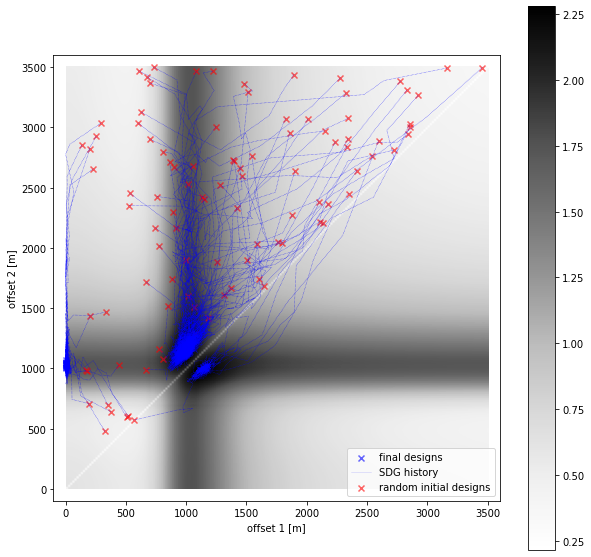

In [52]:
eig_grid = eig_global.reshape((n_design_points, n_design_points)).numpy()

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(eig_grid,
          origin='lower',
          extent=[1, 3500, 1, 3500],
        #   alpha=0.8,
          cmap='Greys')

ax.scatter(design_history_collection[:, -1, 0].T,
           design_history_collection[:, -1, 1].T,
           alpha=0.6,
           marker='x',
           color='b',
           clip_on=False,
           label='final designs',
           zorder=10)

ax.plot(design_history_collection[:, ::1000, 0].T, design_history_collection[:, ::1000, 1].T,
        color='b', alpha=1.0, linestyle=':', linewidth=0.5, marker='None', clip_on=False, )
ax.plot([], [],
        color='b', alpha=0.2, linewidth=0.5, marker='None', clip_on=False, label='SDG history')

ax.scatter(design_history_collection[:, 0, 0].T,
           design_history_collection[:, 0, 1].T,
           alpha=0.6,
           marker='x',
           color='r',
           clip_on=False,
           label='random initial designs')



ax.set_xlim(-100, 3600)
ax.set_ylim(-100, 3600)

ax.set_xlabel('offset 1 [m]')
ax.set_ylabel('offset 2 [m]')

ax.legend(loc='lower right')

plt.colorbar(im)

fig.savefig('figures/avo_gaussian_2rec_global_optimum_eig.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_gaussian_2rec_global_optimum_eig.png', bbox_inches='tight',
            dpi=120, transparent=True)

plt.show()